In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R
#from filtros import files_xsensexporter_grouping as test1
from mpl_toolkits.mplot3d import Axes3D
from pythreejs import *
from IPython.display import display
import time
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from vpython import canvas, cylinder, vector, color, rate, button
import gc
from scipy.signal import butter, filtfilt



<IPython.core.display.Javascript object>

In [3]:
gc.collect()
#Aqui estoy

12

## INTENTO DE CÁLCULO CON F/E RODILLA #1

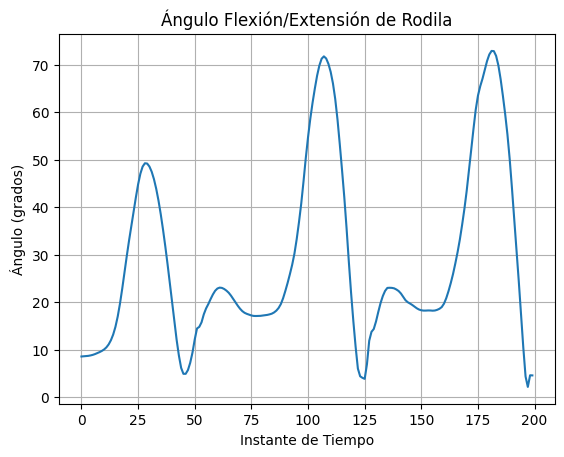

In [3]:
#muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\muslo_der_D422CD002A96_20241123_104840.csv")
#tibia_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\tibia_der_D422CD0041E2_20241123_104840.csv")
#pie_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\pie_der_D422CD002A85_20241123_104840.csv")

muslo_data=pd.read_csv(r'C:\Users\mv.pinzon\OneDrive - Universidad de los andes\Documentos\GitHub\IMU-3D-Kinematics\data\sesion 1 ministerio\110449\muslo_der_val_D422CD002A96_20241004_110449.csv')
tibia_data=pd.read_csv(r'C:\Users\mv.pinzon\OneDrive - Universidad de los andes\Documentos\GitHub\IMU-3D-Kinematics\data\sesion 1 ministerio\110449\tibia_der_val_D422CD0041E2_20241004_110449.csv')
pie_data=pd.read_csv(r'C:\Users\mv.pinzon\OneDrive - Universidad de los andes\Documentos\GitHub\IMU-3D-Kinematics\data\sesion 1 ministerio\110449\pie_der_val_D422CD002A85_20241004_110449.csv')

# Asegurarse  que los archivos tengan las columnas correctas y que estén alineados
min_length = min(len(muslo_data), len(tibia_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]

# Convertir los cuaterniones a matrices de rotación (usamos los datos de los cuaterniones)
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    """Convierte cuaterniones a matrices de rotación."""
    q = np.array([qw, qx, qy, qz])  # Asegúrate de que el orden sea [qw, qx, qy, qz]
    r = R.from_quat(q)  # Convierte el cuaternión a una rotación 3D
    return r.as_matrix()  # Devuelve la matriz de rotación

# Obtener las matrices de rotación para muslo y tibia
rotaciones_muslo = muslo_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = tibia_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

#matrices de rotación R_SB para muslo y tibia (esto se calcula con la calibración)
R_SB_muslo = np.identity(3)  
R_SB_tibia = np.identity(3)

# Aplicar la transformación de las matrices de rotación a las matrices de rotación del sensor
rotaciones_globales_muslo = [R_SB_muslo @ rot for rot in rotaciones_muslo]
rotaciones_globales_tibia = [R_SB_tibia @ rot for rot in rotaciones_tibia]

# 5. Calcular el ángulo entre los segmentos
def calcular_angulo(R_muslo, R_tibia):
    """Calcula el ángulo entre dos segmentos utilizando matrices de rotación."""
    # Tomamos el vector de la dirección de los segmentos
    # Se asume que el segmento apunta en la dirección negativa del eje Y en el sistema de coordenadas del sensor
    vector_muslo = R_muslo @ np.array([1, 0, 0])  # Dirección del muslo
    vector_tibia = R_tibia @ np.array([1, 0, 0])  # Dirección de la tibia     
    
    # Calcular el ángulo entre los dos vectores usando el producto punto
    producto_punto = np.dot(vector_muslo, vector_tibia)
    norma_muslo = np.linalg.norm(vector_muslo)
    norma_tibia = np.linalg.norm(vector_tibia)
    
    # Ángulo en radianes
    angulo_radianes = np.arccos(producto_punto / (norma_muslo * norma_tibia))
    
    # Convertir el ángulo a grados
    angulo_grados = np.degrees(angulo_radianes)
    return angulo_grados

# 6. Calcular los ángulos para todas las muestras
angulos = [calcular_angulo(R_muslo, R_tibia) for R_muslo, R_tibia in zip(rotaciones_muslo, rotaciones_tibia)]

# 7. Graficar los ángulos
plt.plot(angulos[0:200])
plt.title('Ángulo Flexión/Extensión de Rodila')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.grid(True)
plt.show()

# Mostrar algunos valores de los ángulos calculados print("Algunos ángulos calculados:", angulos[:10])

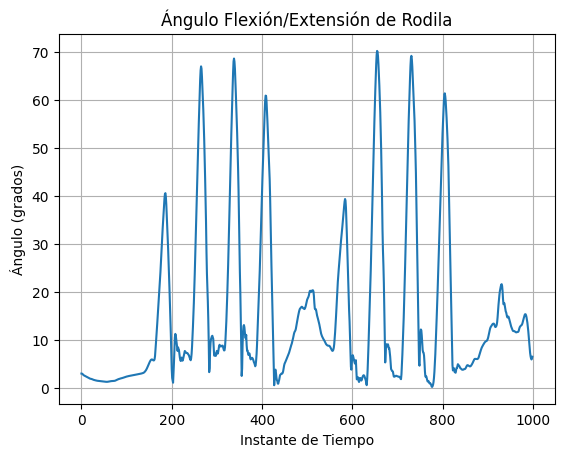

Algunos ángulos calculados: [2.9739762455934526, 2.9643002820504556, 2.9118510544959784, 2.8127177488540753, 2.707949267630971, 2.6243053204656106, 2.5721855632216184, 2.518245530570427, 2.4635035152799434, 2.4137988298582154]


In [ ]:
#muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\muslo_der_D422CD002A96_20241123_104840.csv")
#tibia_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\tibia_der_D422CD0041E2_20241123_104840.csv")
#pie_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\pie_der_D422CD002A85_20241123_104840.csv")


#muslo_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\muslo_der_D422CD002A96_20241119_125057.csv')
#tibia_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\tibia_der_D422CD0041E2_20241119_125057.csv')

# Asegurarse  que los archivos tengan las columnas correctas y que estén alineados
min_length = min(len(muslo_data), len(tibia_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]

# Convertir los cuaterniones a matrices de rotación (usamos los datos de los cuaterniones)
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    """Convierte cuaterniones a matrices de rotación."""
    q = np.array([qw, qx, qy, qz])  # Asegúrate de que el orden sea [qw, qx, qy, qz]
    r = R.from_quat(q)  # Convierte el cuaternión a una rotación 3D
    return r.as_matrix()  # Devuelve la matriz de rotación

# Obtener las matrices de rotación para muslo y tibia
rotaciones_muslo = muslo_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = tibia_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

#matrices de rotación R_SB para muslo y tibia (esto se calcula con la calibración)
R_SB_muslo = np.identity(3)  
R_SB_tibia = np.identity(3)

# Aplicar la transformación de las matrices de rotación a las matrices de rotación del sensor
rotaciones_globales_muslo = [R_SB_muslo @ rot for rot in rotaciones_muslo]
rotaciones_globales_tibia = [R_SB_tibia @ rot for rot in rotaciones_tibia]

# 5. Calcular el ángulo entre los segmentos
def calcular_angulo(R_muslo, R_tibia):
    """Calcula el ángulo entre dos segmentos utilizando matrices de rotación."""
    # Tomamos el vector de la dirección de los segmentos
    # Se asume que el segmento apunta en la dirección negativa del eje Y en el sistema de coordenadas del sensor
    vector_muslo = R_muslo @ np.array([1, 0, 0])  # Dirección del muslo
    vector_tibia = R_tibia @ np.array([1, 0, 0])  # Dirección de la tibia     
    
    # Calcular el ángulo entre los dos vectores usando el producto punto
    producto_punto = np.dot(vector_muslo, vector_tibia)
    norma_muslo = np.linalg.norm(vector_muslo)
    norma_tibia = np.linalg.norm(vector_tibia)
    
    # Ángulo en radianes
    angulo_radianes = np.arccos(producto_punto / (norma_muslo * norma_tibia))
    
    # Convertir el ángulo a grados
    angulo_grados = np.degrees(angulo_radianes)
    return angulo_grados

# 6. Calcular los ángulos para todas las muestras
angulos = [calcular_angulo(R_muslo, R_tibia) for R_muslo, R_tibia in zip(rotaciones_muslo, rotaciones_tibia)]

# 7. Graficar los ángulos
plt.plot(angulos[0:1000])
plt.title('Ángulo Flexión/Extensión de Rodila')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.grid(True)
plt.show()

# Mostrar algunos valores de los ángulos calculados
print("Algunos ángulos calculados:", angulos[:10])
#

## INTENTO DE CÁLCULO CON F/E TOBILLO #1

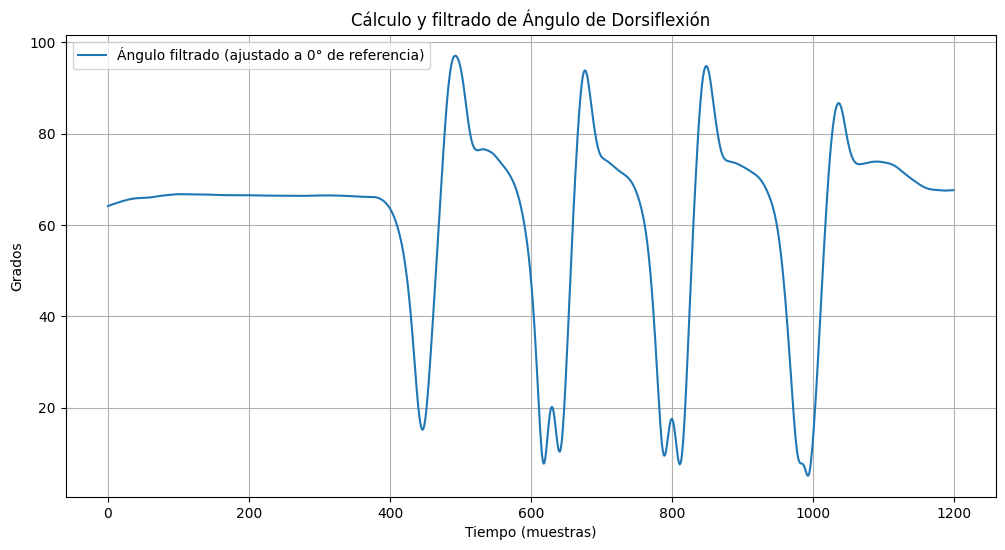

In [ ]:

muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\muslo_der_D422CD002A96_20241123_105027.csv")
tibia_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\tibia_der_D422CD0041E2_20241123_105027.csv")
pie_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\pie_der_D422CD002A85_20241123_105027.csv")

# Asegurar que ambas señales tengan la misma longitud
min_length = min(len(tibia_data), len(pie_data))
tibia_data = tibia_data[:min_length]
pie_data = pie_data[:min_length]


# Función para convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    """
    Convierte un cuaternión a una matriz de rotación 3D.
    Args:
        qw, qx, qy, qz: Componentes de cuaternión.
    Returns:
        Matriz de rotación 3D correspondiente.
    """
    q = [qw, qx, qy, qz]
    rot = R.from_quat(q)  # Convierte a una rotación 3D
    return rot.as_matrix()


# Crear las matrices de rotación para tibia y pie
rotaciones_tibia = np.array([
    cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']) for index, row in tibia_data.iterrows()
])
rotaciones_pie = np.array([
    cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']) for index, row in pie_data.iterrows()
])


# Función para ajustar el pie 90° alrededor del eje X (según tu modelo)
def ajustar_pie(rot_pie):
    """
    Ajusta la orientación del pie para alinearlo con la referencia de la tibia.
    Args:
        rot_pie: Matriz de rotación asociada al pie.
    Returns:
        Matriz ajustada.
    """
    # Crear una rotación de 90 grados en torno al eje X
    rot_90_x = R.from_euler('x', 90, degrees=True).as_matrix()
    # Ajustar la rotación
    return rot_pie @ rot_90_x


# Función para calcular el ángulo de dorsiflexión
def calcular_dorsiflexion(rot_tibia, rot_pie):
    """
    Calcula el ángulo de dorsiflexión entre la tibia y el pie ajustado.
    Args:
        rot_tibia: Matriz de rotación para la tibia.
        rot_pie: Matriz ajustada de rotación para el pie.
    Returns:
        Ángulo de dorsiflexión en grados ajustado para el rango.
    """
    # Relación de rotaciones
    rot_relativa = np.linalg.inv(rot_tibia) @ rot_pie
    # Extraer el componente Z
    eje_z_relativo = rot_relativa[:, 2]
    # Calcular ángulo (arccos del componente Z)
    angulo_dorsiflexion = np.degrees(np.arccos(np.clip(eje_z_relativo[2], -1, 1)))
    
    # Ajustar el rango para que 0 corresponda a la posición de bípedo con el pie en el suelo
    angulo_dorsiflexion -= 30  # Ajustar la referencia para que sea más realista
    angulo_dorsiflexion = np.clip(angulo_dorsiflexion, -30, 30)  # Limitar el rango
    return angulo_dorsiflexion


# Filtro pasa-bajo sutil (filtro Butterworth)
def filtro_lowpass(data, cutoff_freq=0.1, sampling_rate=100):
    """
    Aplica un filtro Butterworth pasa bajo a la señal para suavizarla.
    Args:
        data: Señal de entrada
        cutoff_freq: Frecuencia de corte normalizada (0-1)
        sampling_rate: Frecuencia de muestreo
    Returns:
        Señal filtrada
    """
    # Diseño del filtro Butterworth
    b, a = butter(N=2, Wn=cutoff_freq, btype='low')
    # Aplicar filtro a la señal
    return filtfilt(b, a, data)


# Procesar los datos para calcular los ángulos
angulos_dorsiflexion = []
for i in range(len(rotaciones_tibia)):
    # Ajustar el pie
    rot_pie_ajustado = ajustar_pie(rotaciones_pie[i])
    # Calcular la dorsiflexión ajustada
    angulo = calcular_dorsiflexion(rotaciones_tibia[i], rot_pie_ajustado)
    angulos_dorsiflexion.append(angulo)

# Convertir a array de numpy
angulos_dorsiflexion = np.array(angulos_dorsiflexion)

# Establecer el primer valor como referencia 0°
angulo_referencia = angulos_dorsiflexion[0]  # Ángulo inicial de referencia
angulos_dorsiflexion -= angulo_referencia  # Restar la referencia a todas las muestras

# Aplicar filtro pasa-bajo para suavizar la señal
angulos_dorsiflexion_filtrados = filtro_lowpass(angulos_dorsiflexion)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(angulos_dorsiflexion_filtrados[0:1200], label="Ángulo filtrado (ajustado a 0° de referencia)")
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Grados')
plt.title('Cálculo y filtrado de Ángulo de Dorsiflexión')
plt.legend()
plt.grid()
plt.show()



### Vamos a graficarlos con Awinda

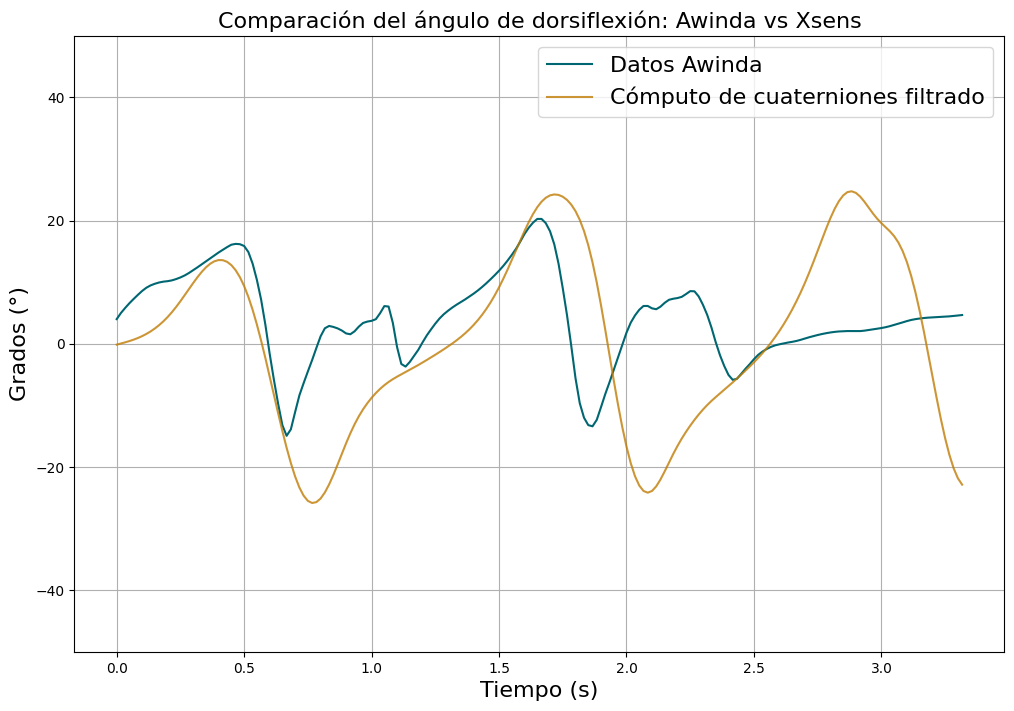

Coeficiente de correlación de Pearson: 0.31427548964781854


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.spatial.transform import Rotation as R
from scipy.stats import pearsonr

# Cargar datos de Awinda
archivo_awinda = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\Datos Awinda\Marcha-002.xlsx'
df_awinda = pd.read_excel(archivo_awinda, sheet_name='Joint Angles ZXY')

# Validar si la columna de interés existe
if 'Right Ankle Dorsiflexion/Plantarflexion' in df_awinda.columns:
    datos_awinda = df_awinda['Right Ankle Dorsiflexion/Plantarflexion'].values[:1200]  # Tomar las primeras muestras para la comparación
else:
    raise ValueError("La columna 'Right Ankle Dorsiflexion/Plantarflexion' no existe en la hoja 'Joint Angles ZXY'")

# Cargar datos de tibia y pie
tibia_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\tibia_der_val_D422CD0041E2_20241004_110449.csv')
pie_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\pie_der_val_D422CD002A85_20241004_110449.csv')

# Función para convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    """
    Convierte un cuaternión a una matriz de rotación 3D.
    Args:
        qw, qx, qy, qz: Componentes de cuaternión.
    Returns:
        Matriz de rotación 3D correspondiente.
    """
    q = [qw, qx, qy, qz]
    rot = R.from_quat(q)  # Convierte a una rotación 3D
    return rot.as_matrix()


# Crear las matrices de rotación para tibia y pie
rotaciones_tibia = np.array([
    cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']) for index, row in tibia_data.iterrows()
])
rotaciones_pie = np.array([
    cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']) for index, row in pie_data.iterrows()
])


# Función para ajustar el pie 90° alrededor del eje X (según tu modelo)
def ajustar_pie(rot_pie):
    """
    Ajusta la orientación del pie para alinearlo con la referencia de la tibia.
    Args:
        rot_pie: Matriz de rotación asociada al pie.
    Returns:
        Matriz ajustada.
    """
    # Crear una rotación de 90 grados en torno al eje X
    rot_90_x = R.from_euler('x', 90, degrees=True).as_matrix()
    # Ajustar la rotación
    return rot_pie @ rot_90_x


# Función para calcular el ángulo de dorsiflexión
def calcular_dorsiflexion(rot_tibia, rot_pie):
    """
    Calcula el ángulo de dorsiflexión entre la tibia y el pie ajustado.
    Args:
        rot_tibia: Matriz de rotación para la tibia.
        rot_pie: Matriz ajustada de rotación para el pie.
    Returns:
        Ángulo de dorsiflexión en grados ajustado para el rango.
    """
    # Relación de rotaciones
    rot_relativa = np.linalg.inv(rot_tibia) @ rot_pie
    # Extraer el componente Z
    eje_z_relativo = rot_relativa[:, 2]
    # Calcular ángulo (arccos del componente Z)
    angulo_dorsiflexion = np.degrees(np.arccos(np.clip(eje_z_relativo[2], -1, 1)))
    
    # Ajustar el rango para que 0 corresponda a la posición de bípedo con el pie en el suelo
    angulo_dorsiflexion -= 30  # Ajustar la referencia para que sea más realista
    angulo_dorsiflexion = np.clip(angulo_dorsiflexion, -30, 30)  # Limitar el rango
    return angulo_dorsiflexion


# Función para aplicar filtro Butterworth pasa bajo
def filtro_lowpass(data, cutoff_freq=0.1, sampling_rate=100):
    """
    Aplica un filtro Butterworth pasa bajo a la señal para suavizarla.
    Args:
        data: Señal de entrada
        cutoff_freq: Frecuencia de corte normalizada (0-1)
        sampling_rate: Frecuencia de muestreo
    Returns:
        Señal filtrada
    """
    # Diseño del filtro Butterworth
    b, a = butter(N=2, Wn=cutoff_freq, btype='low')
    # Aplicar filtro a la señal
    return filtfilt(b, a, data)


# Procesar los datos para calcular los ángulos
angulos_dorsiflexion = []
for i in range(len(rotaciones_tibia)):
    # Ajustar el pie
    rot_pie_ajustado = ajustar_pie(rotaciones_pie[i])
    # Calcular la dorsiflexión ajustada
    angulo = calcular_dorsiflexion(rotaciones_tibia[i], rot_pie_ajustado)
    angulos_dorsiflexion.append(angulo)

# Convertir a array de numpy
angulos_dorsiflexion = np.array(angulos_dorsiflexion)

# Establecer el primer valor como referencia 0° para alinear ambos
angulo_referencia = angulos_dorsiflexion[0]  # Ángulo inicial de referencia
angulos_dorsiflexion -= angulo_referencia # Restar la referencia a todas las muestras

# Aplicar filtro pasa-bajo para suavizar la señal
angulos_dorsiflexion_filtrados = filtro_lowpass(angulos_dorsiflexion)

# Colors
azul = "#006772"
amarillo = "#c07c04"

# Crear el eje temporal basado en la frecuencia de muestreo de 60 Hz
tiempo = np.arange(len(datos_awinda)) / 60  # Convierte las muestras a tiempo en segundos
tiempo_calculado = np.arange(len(angulos_dorsiflexion_filtrados[:1200])) / 60

# Graficar los datos comparados con tiempo
plt.figure(figsize=(12, 8))
plt.plot(tiempo[:200], datos_awinda[110:310], label="Datos Awinda", color=azul)
plt.plot(tiempo[:200], angulos_dorsiflexion_filtrados[:200], label="Cómputo de cuaterniones filtrado", alpha=0.8, color=amarillo)
plt.xlabel('Tiempo (s)', fontsize=16)
plt.ylabel('Grados (°)', fontsize=16)
plt.ylim(-50,50)
plt.title("Comparación del ángulo de dorsiflexión: Awinda vs Xsens", fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()

# Asegurar que los datos comparados tengan la misma longitud
min_muestras = min(len(datos_awinda[110:310]), len(angulos_dorsiflexion_filtrados[:200]))
datos_awinda_comparacion = datos_awinda[110:310][:min_muestras]
angulos_dorsiflexion_filtrados_comparacion = angulos_dorsiflexion_filtrados[:min_muestras]

# Calcular la correlación de Pearson
correlation_coefficient, _ = pearsonr(datos_awinda_comparacion, angulos_dorsiflexion_filtrados_comparacion)

# Imprimir el coeficiente de correlación
print(f"Coeficiente de correlación de Pearson: {correlation_coefficient}")

### Xsens - Awinda Rodilla

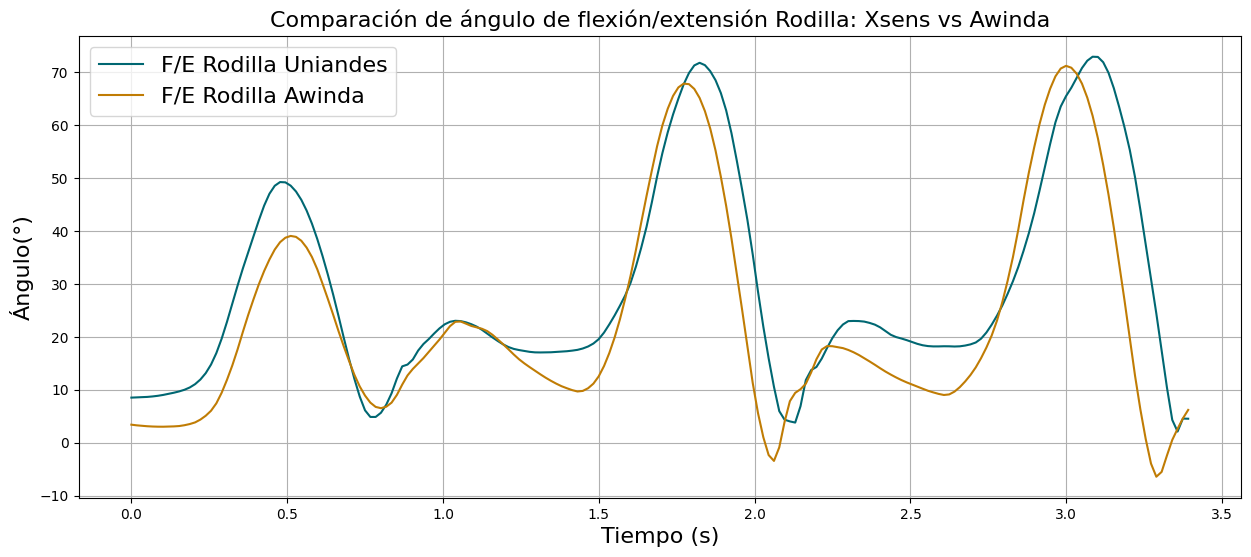

NameError: name 'pearsonr' is not defined

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.spatial.transform import Rotation as R


# Cargar datos de Xsens (muslo y tibia)
muslo_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\muslo_der_val_D422CD002A96_20241004_110449.csv')
tibia_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\tibia_der_val_D422CD0041E2_20241004_110449.csv')

# Asegurar que ambos datos estén del mismo tamaño
min_length = min(len(muslo_data), len(tibia_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]


# Convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    """Convierte cuaterniones a matrices de rotación."""
    q = np.array([qw, qx, qy, qz])  # [qw, qx, qy, qz]
    r = R.from_quat(q)  # Convierte el cuaternión a una rotación 3D
    return r.as_matrix()


# Obtener matrices de rotación para muslo y tibia
rotaciones_muslo = muslo_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = tibia_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

# Asignar matrices de referencia de calibración (R_SB)
R_SB_muslo = np.identity(3)
R_SB_tibia = np.identity(3)

# Transformar matrices globales
rotaciones_globales_muslo = [R_SB_muslo @ rot for rot in rotaciones_muslo]
rotaciones_globales_tibia = [R_SB_tibia @ rot for rot in rotaciones_tibia]


# Función para calcular ángulos de flexión/extensión
def calcular_angulo(R_muslo, R_tibia):
    """Calcula el ángulo entre dos segmentos utilizando matrices de rotación."""
    vector_muslo = R_muslo @ np.array([1, 0, 0])  # Dirección del muslo
    vector_tibia = R_tibia @ np.array([1, 0, 0])  # Dirección de la tibia
    
    producto_punto = np.dot(vector_muslo, vector_tibia)
    norma_muslo = np.linalg.norm(vector_muslo)
    norma_tibia = np.linalg.norm(vector_tibia)
    
    # Ángulo en radianes
    angulo_radianes = np.arccos(producto_punto / (norma_muslo * norma_tibia))
    
    # Convertir a grados
    angulo_grados = np.degrees(angulo_radianes)
    return angulo_grados


# Calcular los ángulos
angulos = [calcular_angulo(R_muslo, R_tibia) for R_muslo, R_tibia in zip(rotaciones_globales_muslo, rotaciones_globales_tibia)]

# Cargar datos Awinda
archivo_awinda = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\Datos Awinda\Marcha-002.xlsx'
df_awinda = pd.read_excel(archivo_awinda, sheet_name='Joint Angles ZXY')

# Validar si la columna de interés existe
if 'Right Knee Flexion/Extension' in df_awinda.columns:
    datos_awinda = df_awinda['Right Knee Flexion/Extension'].values[:len(angulos)]  # Ajustar la cantidad de datos para comparar
else:
    raise ValueError("La columna 'Right Knee Flexion/Extension' no existe en la hoja 'Joint Angles ZXY'")


# Crear la línea temporal común
tiempo = np.linspace(0, 60, len(angulos))  # Línea de tiempo ajustada a la cantidad de datos de Xsens y Awinda
azul = "#006772"
amarillo = "#c07c04"

# Graficar todo en el mismo tiempo
plt.figure(figsize=(15, 6))
plt.plot(tiempo[0:200], angulos[0:200], label='F/E Rodilla Uniandes',color=azul)
plt.plot(tiempo[0:200], datos_awinda[50:250], label='F/E Rodilla Awinda', color=amarillo)
plt.xlabel('Tiempo (s)', fontsize=16)
plt.ylabel('Ángulo(°)', fontsize=16)
plt.legend(fontsize=16)
plt.title('Comparación de ángulo de flexión/extensión Rodilla: Xsens vs Awinda', fontsize=16)
plt.grid()
plt.show()

# Asegurar que ambas series tengan la misma longitud para la correlación
# Seleccionamos los subconjuntos equivalentes
angulos_segmento = angulos[0:200]  # Segmento de los datos Xsens
datos_awinda_segmento = datos_awinda[50:250]  # Segmento de los datos Awinda

# Verificar que tienen la misma longitud
if len(angulos_segmento) == len(datos_awinda_segmento):
    # Calcular la correlación de Pearson
    correlacion, p_valor = pearsonr(angulos_segmento, datos_awinda_segmento)
    
    # Mostrar resultados
    print(f"Coeficiente de correlación de Pearson: {correlacion}")
    print(f"P-valor: {p_valor}")
else:
    print("Los subconjuntos de datos no tienen la misma longitud para la correlación.")


# XSENS - 3DMA 

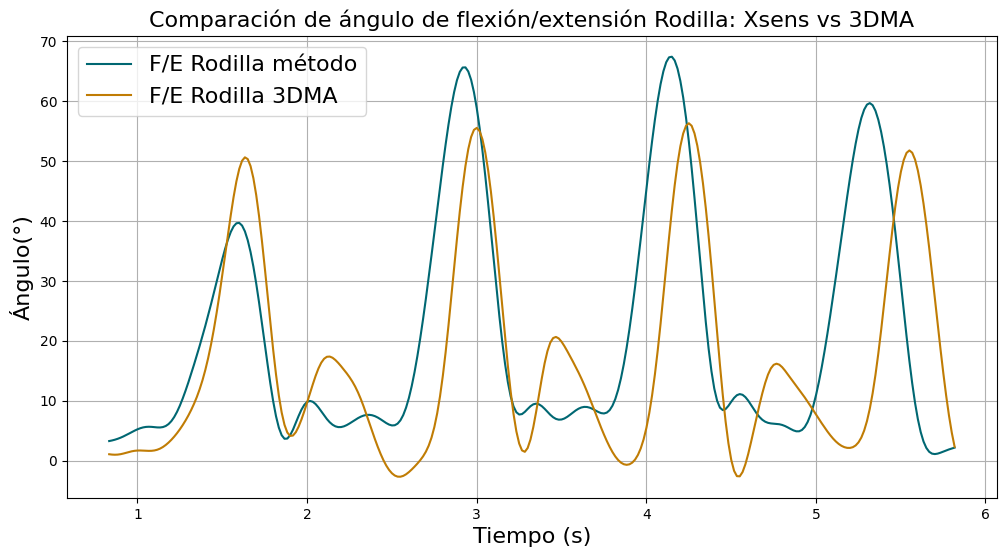

NameError: name 'pearsonr' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import interp1d

# Leer los archivos CSV
muslo_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\muslo_der_D422CD002A96_20241119_125057.csv')
tibia_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\tibia_der_D422CD0041E2_20241119_125057.csv')
knee_3dma_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\\3DMA\marcha 1\knee angles.csv', sep=';', decimal=',', encoding='utf-8')

# Asegurarse que los archivos tengan la misma longitud
min_length = min(len(muslo_data), len(tibia_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]

# Convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    """Convierte cuaterniones a matrices de rotación."""
    q = np.array([qw, qx, qy, qz])
    r = R.from_quat(q)
    return r.as_matrix()

# Obtener las matrices de rotación para muslo y tibia
rotaciones_muslo = muslo_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = tibia_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

# Matrices de rotación de referencia para muslo y tibia
R_SB_muslo = np.identity(3)
R_SB_tibia = np.identity(3)

# Transformar las matrices de rotación
rotaciones_globales_muslo = [R_SB_muslo @ rot for rot in rotaciones_muslo]
rotaciones_globales_tibia = [R_SB_tibia @ rot for rot in rotaciones_tibia]

# Función para calcular el ángulo entre muslo y tibia
def calcular_angulo(R_muslo, R_tibia):
    """Calcula el ángulo entre dos segmentos utilizando matrices de rotación."""
    vector_muslo = R_muslo @ np.array([1, 0, 0])
    vector_tibia = R_tibia @ np.array([1, 0, 0])
    
    producto_punto = np.dot(vector_muslo, vector_tibia)
    norma_muslo = np.linalg.norm(vector_muslo)
    norma_tibia = np.linalg.norm(vector_tibia)
    
    angulo_radianes = np.arccos(producto_punto / (norma_muslo * norma_tibia))
    angulo_grados = np.degrees(angulo_radianes)
    return angulo_grados

# Calcular los ángulos
angulos = [calcular_angulo(R_muslo, R_tibia) for R_muslo, R_tibia in zip(rotaciones_globales_muslo, rotaciones_globales_tibia)]

# Función para aplicar filtro Butterworth
def filtrar_ángulos(data, frecuencia_muestreo, frecuencia_corte):
    """
    Aplica un filtro Butterworth de paso bajo a los datos de ángulos para suavizar la señal.
    - frecuencia_muestreo: Frecuencia de muestreo de los datos.
    - frecuencia_corte: Frecuencia de corte del filtro Butterworth en Hz.
    """
    nyquist = 0.5 * frecuencia_muestreo
    normalizada = frecuencia_corte / nyquist
    b, a = butter(N=4, Wn=normalizada, btype='low')
    datos_filtrados = filtfilt(b, a, data)
    return datos_filtrados

# Parámetros del filtro
frecuencia_muestreo = 60  # Frecuencia de muestreo de los datos
frecuencia_corte = 4  # Frecuencia de corte en Hz

# Aplicar el filtro
angulos_filtrados = filtrar_ángulos(angulos, frecuencia_muestreo, frecuencia_corte)

# Interpolación de datos 3DMA para alinearse a la frecuencia de 60 Hz
tiempo_3dma = np.linspace(0, len(knee_3dma_data) / 240, len(knee_3dma_data))  # Tiempo original en 240 Hz
interpolador = interp1d(tiempo_3dma, knee_3dma_data['Right Knee Flexion/Extension::Y'], fill_value="extrapolate")
tiempo_60hz = np.linspace(0, len(angulos_filtrados) / frecuencia_muestreo, len(angulos_filtrados))
knee_3dma_interpolado = interpolador(tiempo_60hz)

azul = "#006772"
amarillo = "#c07c04"
# Graficar los resultados ajustando el tiempo en segundos para el eje x
plt.figure(figsize=(12, 6))
plt.plot(tiempo_60hz[50:350], angulos_filtrados[140:440], label='F/E Rodilla método', color=azul)
plt.plot(tiempo_60hz[50:350], knee_3dma_interpolado[50:350], label='F/E Rodilla 3DMA', color=amarillo)
plt.title('Comparación de ángulo de flexión/extensión Rodilla: Xsens vs 3DMA',fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=16)
plt.ylabel('Ángulo(°)', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()


coef_corr, _ = pearsonr(angulos_filtrados[140:440], knee_3dma_interpolado[50:350])
# Imprimir el resultado de la correlación
print(f"Coeficiente de correlación de Pearson: {coef_corr:.3f}")


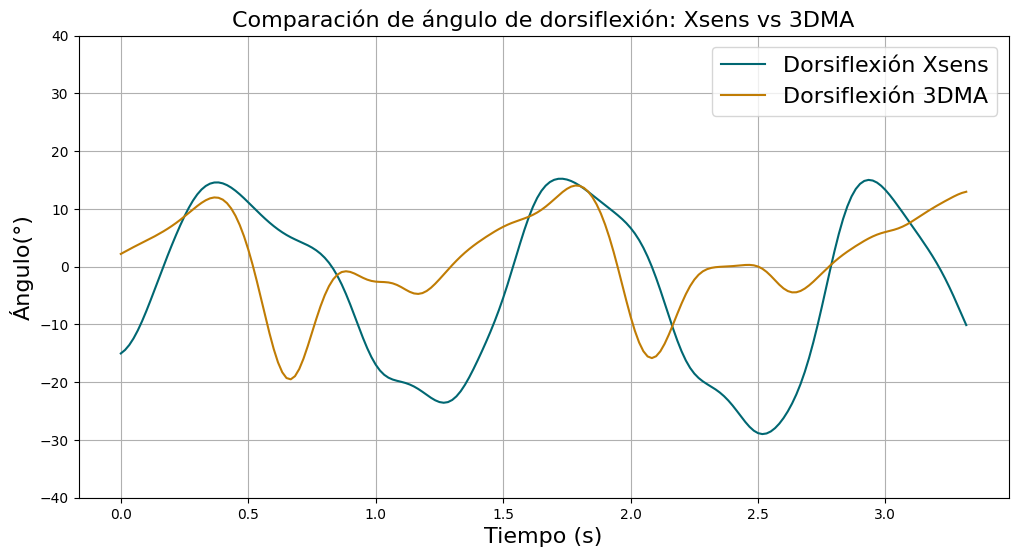

NameError: name 'pearsonr' is not defined

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import interp1d


# Cargar los datos del tobillo (ankle) correctamente

tibia_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\tibia_der_D422CD0041E2_20241119_125057.csv')
pie_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\pie_der_D422CD002A85_20241119_125057.csv')
ankle_3dma_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\\3DMA\marcha 3\ankle angles.csv', sep=';', decimal=',', encoding='utf-8')


# Asegurar que ambas señales tengan la misma longitud
min_length = min(len(tibia_data), len(pie_data))
tibia_data = tibia_data[:min_length]
pie_data = pie_data[:min_length]


# Función para convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    """
    Convierte un cuaternión a una matriz de rotación 3D.
    Args:
        qw, qx, qy, qz: Componentes de cuaternión.
    Returns:
        Matriz de rotación 3D correspondiente.
    """
    q = [qw, qx, qy, qz]
    rot = R.from_quat(q)  # Convierte a una rotación 3D
    return rot.as_matrix()


# Crear las matrices de rotación para tibia y pie
rotaciones_tibia = np.array([
    cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']) for index, row in tibia_data.iterrows()
])
rotaciones_pie = np.array([
    cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']) for index, row in pie_data.iterrows()
])


# Función para ajustar el pie 90° alrededor del eje X (según tu modelo)
def ajustar_pie(rot_pie):
    """
    Ajusta la orientación del pie para alinearlo con la referencia de la tibia.
    Args:
        rot_pie: Matriz de rotación asociada al pie.
    Returns:
        Matriz ajustada.
    """
    # Crear una rotación de 90 grados en torno al eje X
    rot_90_x = R.from_euler('x', 90, degrees=True).as_matrix()
    # Ajustar la rotación
    return rot_pie @ rot_90_x


# Función para calcular el ángulo de dorsiflexión
def calcular_dorsiflexion(rot_tibia, rot_pie):
    """
    Calcula el ángulo de dorsiflexión entre la tibia y el pie ajustado.
    Args:
        rot_tibia: Matriz de rotación para la tibia.
        rot_pie: Matriz ajustada de rotación para el pie.
    Returns:
        Ángulo de dorsiflexión en grados ajustado para el rango.
    """
    # Relación de rotaciones
    rot_relativa = np.linalg.inv(rot_tibia) @ rot_pie
    # Extraer el componente Z
    eje_z_relativo = rot_relativa[:, 2]
    # Calcular ángulo (arccos del componente Z)
    angulo_dorsiflexion = np.degrees(np.arccos(np.clip(eje_z_relativo[2], -1, 1)))
    
    # Ajustar el rango para que 0 corresponda a la posición de bípedo con el pie en el suelo
    angulo_dorsiflexion -= 30  # Ajustar la referencia para que sea más realista
    angulo_dorsiflexion = np.clip(angulo_dorsiflexion, -30, 30)  # Limitar el rango
    return angulo_dorsiflexion


# Función para aplicar filtro Butterworth pasa bajo
def filtro_lowpass(data, cutoff_freq=0.1, sampling_rate=100):
    """
    Aplica un filtro Butterworth pasa bajo a la señal para suavizarla.
    Args:
        data: Señal de entrada
        cutoff_freq: Frecuencia de corte normalizada (0-1)
        sampling_rate: Frecuencia de muestreo
    Returns:
        Señal filtrada
    """
    # Diseño del filtro Butterworth
    b, a = butter(N=2, Wn=cutoff_freq, btype='low')
    # Aplicar filtro a la señal
    return filtfilt(b, a, data)


# Procesar los datos para calcular los ángulos
angulos_dorsiflexion = []
for i in range(len(rotaciones_tibia)):
    # Ajustar el pie
    rot_pie_ajustado = ajustar_pie(rotaciones_pie[i])
    # Calcular la dorsiflexión ajustada
    angulo = calcular_dorsiflexion(rotaciones_tibia[i], rot_pie_ajustado)
    angulos_dorsiflexion.append(angulo)

# Convertir a array de numpy
angulos_dorsiflexion = np.array(angulos_dorsiflexion)

# Establecer el primer valor como referencia 0° para alinear ambos
angulo_referencia = angulos_dorsiflexion[0]  # Ángulo inicial de referencia
angulos_dorsiflexion -= angulo_referencia # Restar la referencia a todas las muestras

# Aplicar filtro pasa-bajo para suavizar la señal
angulos_dorsiflexion_filtrados = filtro_lowpass(angulos_dorsiflexion)

# Establecer el primer valor como referencia 0°
angulo_referencia = angulos_dorsiflexion[0]  # Ángulo inicial de referencia
angulos_dorsiflexion -= angulo_referencia  # Restar la referencia a todas las muestras

# Aplicar filtro pasa-bajo para suavizar la señal
angulos_dorsiflexion_filtrados = filtro_lowpass(angulos_dorsiflexion)

# Interpolación de datos 3DMA para alinearse a la señal de frecuencia del análisis
tiempo_3dma = np.linspace(0, len(ankle_3dma_data) / 240, len(ankle_3dma_data))  # Tiempo original en 240 Hz
interpolador = interp1d(tiempo_3dma, ankle_3dma_data['Right Ankle Dorsal/Plantar Flexion::Y'], fill_value="extrapolate")
tiempo_60hz = np.linspace(0, len(angulos_dorsiflexion_filtrados) / 60, len(angulos_dorsiflexion_filtrados))
ankle_3dma_interpolado = interpolador(tiempo_60hz)

azul = "#006772"
amarillo = "#c07c04"

# Graficar los resultados ajustando el tiempo en segundos para el eje x
plt.figure(figsize=(12, 6))
plt.plot(tiempo_60hz[0:200], angulos_dorsiflexion_filtrados[185:385], label='Dorsiflexión Xsens', color=azul)
plt.plot(tiempo_60hz[0:200], ankle_3dma_interpolado[150:350], label='Dorsiflexión 3DMA', color=amarillo)
plt.title('Comparación de ángulo de dorsiflexión: Xsens vs 3DMA', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=16)
plt.ylabel('Ángulo(°)', fontsize=16)
plt.ylim(-40,40)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()



# Calcular la correlación de Pearson
seccion_xsens = angulos_dorsiflexion_filtrados[185:385]
seccion_3dma = ankle_3dma_interpolado[150:350]

# Calcular el coeficiente de correlación de Pearson
corr_pearson, _ = pearsonr(seccion_xsens, seccion_3dma)

# Imprimir el resultado
print(f"Coeficiente de correlación de Pearson entre las dos señales es: {corr_pearson:.2f}")

### Intentemos con datos de marcha 3DMA "lo que debería dar"

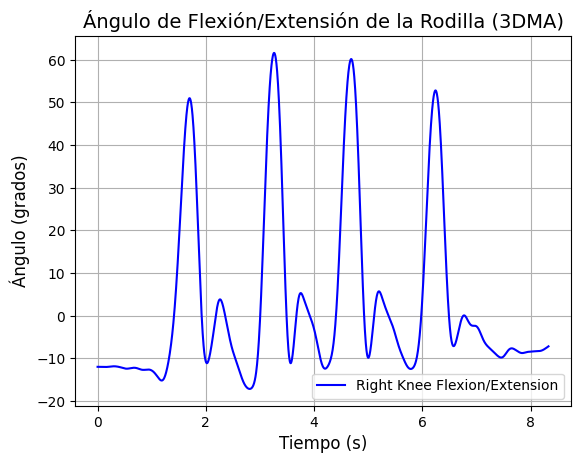

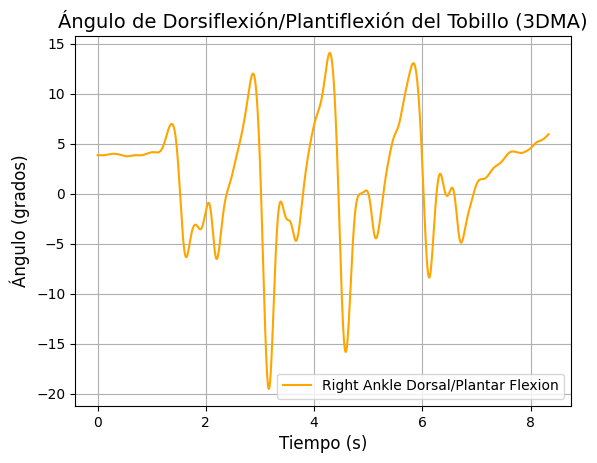

In [ ]:

##### Grafiquemos los datos de 3DMA primero para ir comparando 
# Cargar datos de sensores
muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\muslo_der_D422CD002A96_20241123_105027.csv")
tibia_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\tibia_der_D422CD0041E2_20241123_105027.csv")
pie_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\pie_der_D422CD002A85_20241123_105027.csv")

knee_angles_path = r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\\3DMA\marcha 3\knee angles.csv"
ankle_angles_path =r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\\3DMA\marcha 3\ankle angles.csv"

# Cargar los archivos
#knee_angles_path = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\3DMA\marcha 1\knee angles.csv'
#ankle_angles_path = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\3DMA\marcha 1\ankle angles.csv'

# Leer los datos de los archivos
df_knee = pd.read_csv(knee_angles_path,sep=';', decimal=',', encoding='utf-8')
df_ankle = pd.read_csv(ankle_angles_path, sep=';', decimal=',', encoding='utf-8')

# Extraer las columnas necesarias
time_knee = df_knee['Time']
right_knee = df_knee['Right Knee Flexion/Extension::Y']

time_ankle = df_ankle['Time']
right_ankle = df_ankle['Right Ankle Dorsal/Plantar Flexion::Y']

# Graficar la señal de la rodilla
plt.figure()
plt.plot(time_knee[0:2000], right_knee[0:2000], label='Right Knee Flexion/Extension', color='blue')
plt.title('Ángulo de Flexión/Extensión de la Rodilla (3DMA)', fontsize=14)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Ángulo (grados)', fontsize=12)
#plt.ylim([-10,80])
plt.legend()
plt.grid(True)
plt.show()

# Graficar la señal del tobillo
plt.figure()
plt.plot(time_ankle[0:2000], right_ankle[0:2000], label='Right Ankle Dorsal/Plantar Flexion', color='orange')
plt.title('Ángulo de Dorsiflexión/Plantiflexión del Tobillo (3DMA)', fontsize=14)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Ángulo (grados)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Intentamos con el método anterior y observamos diferencias notables

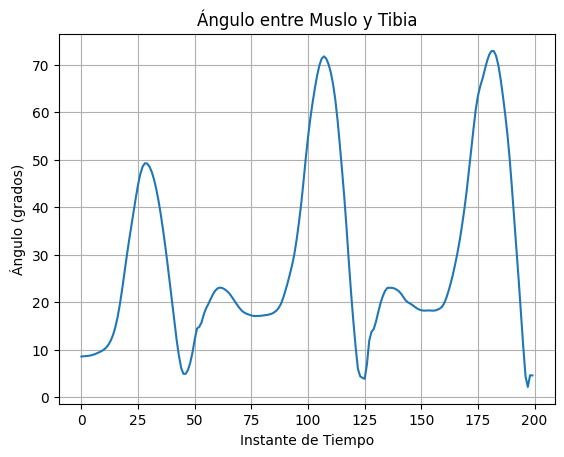

In [57]:

#muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\muslo_der_D422CD002A96_20241123_105027.csv")
#tibia_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\tibia_der_D422CD0041E2_20241123_105027.csv")
#pie_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\105027\pie_der_D422CD002A85_20241123_105027.csv")

muslo_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\muslo_der_val_D422CD002A96_20241004_110449.csv')
tibia_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\tibia_der_val_D422CD0041E2_20241004_110449.csv')
pie_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\pie_der_val_D422CD002A85_20241004_110449.csv')
# Asegurarse  que los archivos tengan las columnas correctas y que estén alineados
min_length = min(len(muslo_data), len(tibia_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]

# Convertir los cuaterniones a matrices de rotación (usamos los datos de los cuaterniones)
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    """Convierte cuaterniones a matrices de rotación."""
    q = np.array([qw, qx, qy, qz])  # Asegúrate de que el orden sea [qw, qx, qy, qz]
    r = R.from_quat(q)  # Convierte el cuaternión a una rotación 3D
    return r.as_matrix()  # Devuelve la matriz de rotación

# Obtener las matrices de rotación para muslo y tibia
rotaciones_muslo = muslo_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = tibia_data.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

#matrices de rotación R_SB para muslo y tibia (esto se calcula con la calibración)
R_SB_muslo = np.identity(3)  
R_SB_tibia = np.identity(3)

# Aplicar la transformación de las matrices de rotación a las matrices de rotación del sensor
rotaciones_globales_muslo = [R_SB_muslo @ rot for rot in rotaciones_muslo]
rotaciones_globales_tibia = [R_SB_tibia @ rot for rot in rotaciones_tibia]

# 5. Calcular el ángulo entre los segmentos
def calcular_angulo(R_muslo, R_tibia):
    """Calcula el ángulo entre dos segmentos utilizando matrices de rotación."""
    # Tomamos el vector de la dirección de los segmentos
    # Se asume que el segmento apunta en la dirección negativa del eje Y en el sistema de coordenadas del sensor
    vector_muslo = R_muslo @ np.array([1, 0, 0])  # Dirección del muslo
    vector_tibia = R_tibia @ np.array([1, 0, 0])  # Dirección de la tibia     
    
    # Calcular el ángulo entre los dos vectores usando el producto punto
    producto_punto = np.dot(vector_muslo, vector_tibia)
    norma_muslo = np.linalg.norm(vector_muslo)
    norma_tibia = np.linalg.norm(vector_tibia)
    
    # Ángulo en radianes
    angulo_radianes = np.arccos(producto_punto / (norma_muslo * norma_tibia))
    
    # Convertir el ángulo a grados
    angulo_grados = np.degrees(angulo_radianes)
    return angulo_grados

# 6. Calcular los ángulos para todas las muestras
angulos = [calcular_angulo(R_muslo, R_tibia) for R_muslo, R_tibia in zip(rotaciones_muslo, rotaciones_tibia)]

# 7. Graficar los ángulos
plt.plot(angulos[0:200])
plt.title('Ángulo entre Muslo y Tibia')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
#plt.ylim([-20,60])
plt.grid(True)
plt.show()


## INTENTO CON MARCHA #2

En este código que sigue, funciona aparentemente la rodilla pero no el tobillo, recordemos que el sensor del pie der esta puesto sobre el empeine, mientras que los de otros segmentos están medio-lateral

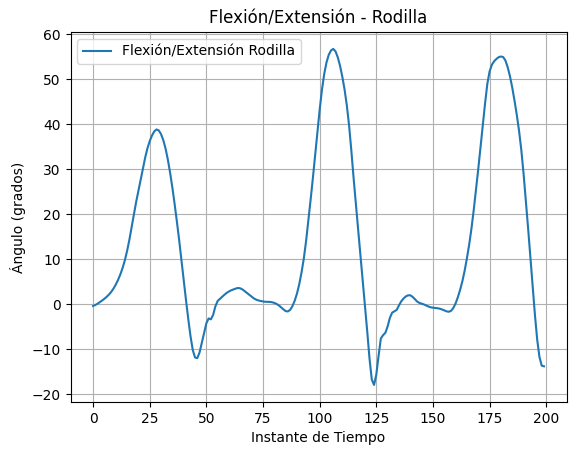

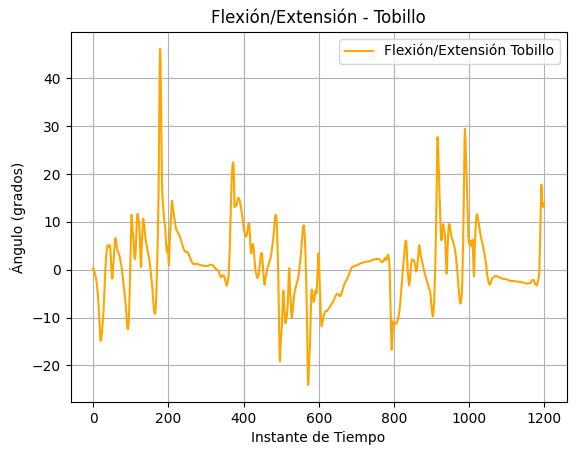

In [9]:
# Función para convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    q = np.array([qw, qx, qy, qz])
    r = R.from_quat(q)
    return r.as_matrix()

# Función para calcular la matriz de calibración promedio 
def calcular_matriz_calibracion(cuaterniones):
    """Toma un DataFrame con cuaterniones y calcula la matriz promedio de las primeras 4 filas."""
    matrices = []
    for i in range(4):  # Solo las primeras 4 filas
        qw, qx, qy, qz = cuaterniones.iloc[i]
        matriz = cuaterniones_a_rotacion(qw, qx, qy, qz)
        matrices.append(matriz)
    return np.mean(matrices, axis=0)

#muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\muslo_der_D422CD002A96_20241119_125057.csv")
#tibia_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\tibia_der_D422CD0041E2_20241119_125057.csv")
#pie_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\marcha 19.11 3DMA y xsens\XSENS\marcha 1\pie_der_D422CD002A85_20241119_125057.csv")


muslo_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\muslo_der_val_D422CD002A96_20241004_110449.csv')
tibia_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\tibia_der_val_D422CD0041E2_20241004_110449.csv')
pie_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\pie_der_val_D422CD002A85_20241004_110449.csv')

# Asegurar que los archivos tengan la misma longitud
min_length = min(len(muslo_data), len(tibia_data), len(pie_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]
pie_data = pie_data[:min_length]

# Extraer cuaterniones 
cuaterniones_muslo = muslo_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
cuaterniones_tibia = tibia_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
cuaterniones_pie = pie_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]

# Calcular matrices de calibración
matriz_calibracion_muslo = calcular_matriz_calibracion(cuaterniones_muslo)
matriz_calibracion_tibia = calcular_matriz_calibracion(cuaterniones_tibia)
matriz_calibracion_pie = calcular_matriz_calibracion(cuaterniones_pie)

# Convertir cuaterniones a matrices de rotación para todo el archivo
rotaciones_muslo = cuaterniones_muslo.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = cuaterniones_tibia.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_pie = cuaterniones_pie.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

# Ajustar orientaciones al sistema anatómico usando matrices de calibración
rotaciones_anatomicas_muslo = [np.linalg.inv(matriz_calibracion_muslo) @ rot for rot in rotaciones_muslo]
rotaciones_anatomicas_tibia = [np.linalg.inv(matriz_calibracion_tibia) @ rot for rot in rotaciones_tibia]
rotaciones_anatomicas_pie = [np.linalg.inv(matriz_calibracion_pie) @ rot for rot in rotaciones_pie]

# Calcular rotaciones relativas
rotaciones_relativas_rodilla = [np.linalg.inv(R_tibia) @ R_muslo for R_muslo, R_tibia in zip(rotaciones_anatomicas_muslo, rotaciones_anatomicas_tibia)]
rotaciones_relativas_tobillo = [np.linalg.inv(R_pie) @ R_tibia for R_tibia, R_pie in zip(rotaciones_anatomicas_tibia, rotaciones_anatomicas_pie)]

# Función para calcular el ángulo de flexión/extensión
def calcular_flexion_extension(rotacion_relativa):
    # Se asume que la flexión/extensión ocurre en el eje X del sistema anatómico
    eje_x = np.array([1, 0, 0])
    vector_direccion = rotacion_relativa @ eje_x
    angulo_radianes = np.arctan2(vector_direccion[2], vector_direccion[0])
    return np.degrees(angulo_radianes)

# Calcular los ángulos de flexión/extensión
flexion_extension_rodilla = [calcular_flexion_extension(rot) for rot in rotaciones_relativas_rodilla]
flexion_extension_tobillo = [calcular_flexion_extension(rot) for rot in rotaciones_relativas_tobillo]

# Graficar los resultados
plt.figure()

plt.plot(flexion_extension_rodilla [0:200], label='Flexión/Extensión Rodilla')
plt.title('Flexión/Extensión - Rodilla')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.grid()

plt.figure()
plt.plot(flexion_extension_tobillo [0:1200], label='Flexión/Extensión Tobillo', color='orange')
plt.title('Flexión/Extensión - Tobillo')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.grid()

plt.show()


INTENTO 3
En las siguientes secciones iteramos con el método para saber cómo vamos mejorando el ajuste de tobillo. Tratemos con datos de marcha y 3DMA

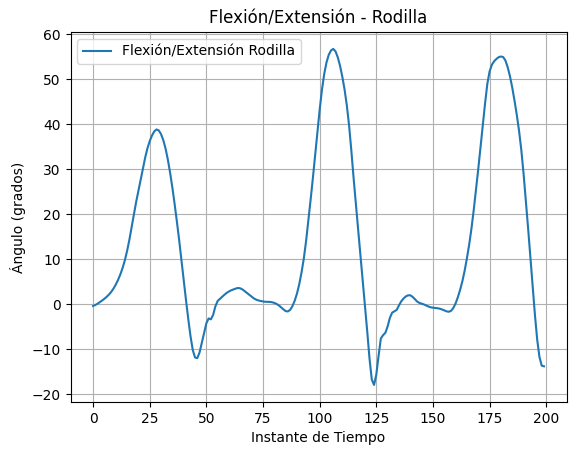

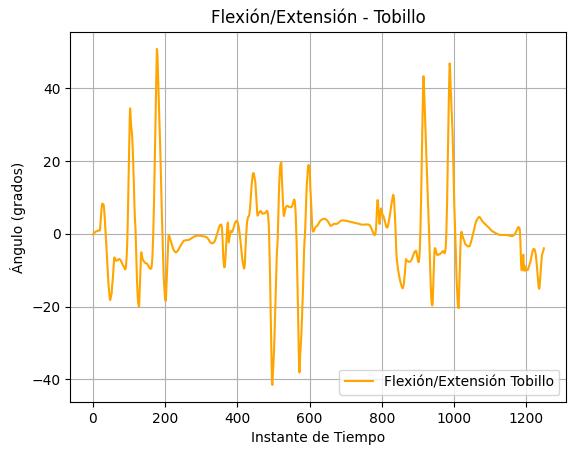

In [10]:
# Función para convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    q = np.array([qw, qx, qy, qz])
    r = R.from_quat(q)
    return r.as_matrix()

# Función para calcular la matriz de calibración promedio
def calcular_matriz_calibracion(cuaterniones):
    """Toma un DataFrame con cuaterniones y calcula la matriz promedio de las primeras 4 filas."""
    matrices = []
    for i in range(4):  # Solo las primeras 4 filas
        qw, qx, qy, qz = cuaterniones.iloc[i]
        matriz = cuaterniones_a_rotacion(qw, qx, qy, qz)
        matrices.append(matriz)
    return np.mean(matrices, axis=0)

# Definir la matriz de rotación que ajusta la orientación del pie
def ajustar_orientacion_pie(rot_pie):
    """
    Ajusta la orientación del sensor del pie (ubicado en el empeine)
    para alinearlo con el sistema de coordenadas de la tibia.
    Este es un ejemplo de rotación arbitraria en el plano sagital.
    Modificar según la orientación real de los sensores.
    """
    # Ejemplo de rotación para ajustar el pie a la tibia
    # Rotación en el plano sagital (ajustar según necesidad)
    angulo_rotacion_sagital = np.deg2rad(-90)  # Ángulo de 15 grados (ajustar según la anatomía)
    rot_sagital = R.from_euler('x', angulo_rotacion_sagital).as_matrix()
    
    # Ajustar la rotación del pie con la rotación en el plano sagital
    return rot_sagital @ rot_pie

# Cargar datos de sensores mindeporte
muslo_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\muslo_der_val_D422CD002A96_20241004_110449.csv')
tibia_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\tibia_der_val_D422CD0041E2_20241004_110449.csv')
pie_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\pie_der_val_D422CD002A85_20241004_110449.csv')

#muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\muslo_der_D422CD002A96_20241123_104840.csv")
#tibia_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\tibia_der_D422CD0041E2_20241123_104840.csv")
#pie_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\pie_der_D422CD002A85_20241123_104840.csv")


# Asegurar que los archivos tengan la misma longitud
min_length = min(len(muslo_data), len(tibia_data), len(pie_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]
pie_data = pie_data[:min_length]

# Extraer cuaterniones
cuaterniones_muslo = muslo_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
cuaterniones_tibia = tibia_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
cuaterniones_pie = pie_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]

# Calcular matrices de calibración
matriz_calibracion_muslo = calcular_matriz_calibracion(cuaterniones_muslo)
matriz_calibracion_tibia = calcular_matriz_calibracion(cuaterniones_tibia)
matriz_calibracion_pie = calcular_matriz_calibracion(cuaterniones_pie)

# Convertir cuaterniones a matrices de rotación para todo el archivo
rotaciones_muslo = cuaterniones_muslo.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = cuaterniones_tibia.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_pie = cuaterniones_pie.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

# Ajustar orientaciones al sistema anatómico usando matrices de calibración
rotaciones_anatomicas_muslo = [np.linalg.inv(matriz_calibracion_muslo) @ rot for rot in rotaciones_muslo]
rotaciones_anatomicas_tibia = [np.linalg.inv(matriz_calibracion_tibia) @ rot for rot in rotaciones_tibia]
rotaciones_anatomicas_pie = [np.linalg.inv(matriz_calibracion_pie) @ rot for rot in rotaciones_pie]

# Ajustar la orientación del pie según la rotación adicional
rotaciones_ajustadas_pie = [ajustar_orientacion_pie(rot) for rot in rotaciones_anatomicas_pie]

# Calcular rotaciones relativas
rotaciones_relativas_rodilla = [np.linalg.inv(R_tibia) @ R_muslo for R_muslo, R_tibia in zip(rotaciones_anatomicas_muslo, rotaciones_anatomicas_tibia)]
rotaciones_relativas_tobillo = [np.linalg.inv(R_pie) @ R_tibia for R_tibia, R_pie in zip(rotaciones_anatomicas_tibia, rotaciones_ajustadas_pie)]

# Función para calcular el ángulo de flexión/extensión
def calcular_flexion_extension(rotacion_relativa):
    eje_x = np.array([1, 0, 0])  # Se asume que la flexión/extensión ocurre en el eje X
    vector_direccion = rotacion_relativa @ eje_x
    angulo_radianes = np.arctan2(vector_direccion[2], vector_direccion[0])
    return np.degrees(angulo_radianes)

# Calcular los ángulos de flexión/extensión
flexion_extension_rodilla = [calcular_flexion_extension(rot) for rot in rotaciones_relativas_rodilla]
flexion_extension_tobillo = [calcular_flexion_extension(rot) for rot in rotaciones_relativas_tobillo]

# Graficar los resultados
plt.figure()
plt.plot(flexion_extension_rodilla[0:200], label='Flexión/Extensión Rodilla')
plt.title('Flexión/Extensión - Rodilla')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.grid()

plt.figure()
plt.plot(flexion_extension_tobillo[0:1250], label='Flexión/Extensión Tobillo', color='orange')
plt.title('Flexión/Extensión - Tobillo')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.grid()

plt.show()

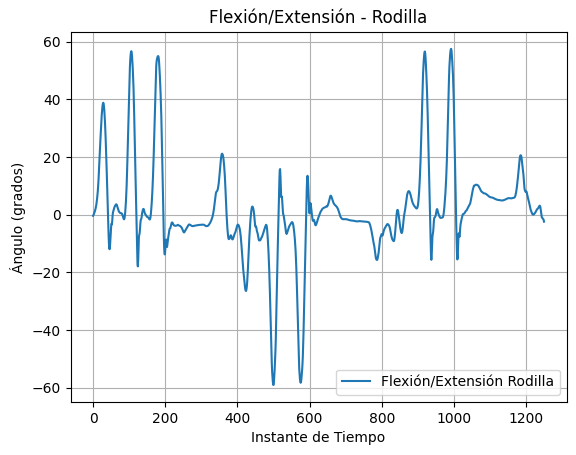

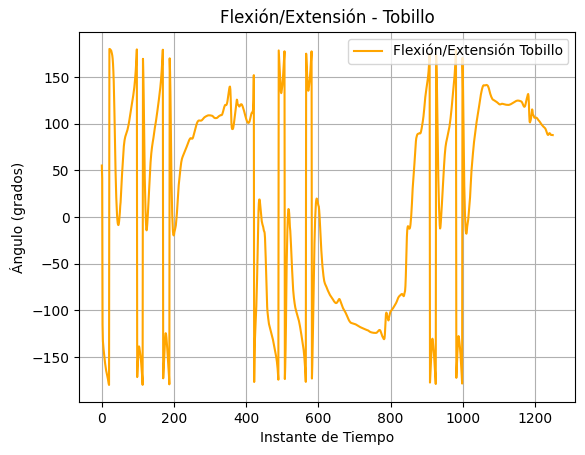

In [17]:
# Función para convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    q = np.array([qw, qx, qy, qz])
    r = R.from_quat(q)
    return r.as_matrix()

# Función para calcular la matriz de calibración promedio
def calcular_matriz_calibracion(cuaterniones):
    """Toma un DataFrame con cuaterniones y calcula la matriz promedio de las primeras 4 filas."""
    matrices = []
    for i in range(4):  # Solo las primeras 4 filas
        qw, qx, qy, qz = cuaterniones.iloc[i]
        matriz = cuaterniones_a_rotacion(qw, qx, qy, qz)
        matrices.append(matriz)
    return np.mean(matrices, axis=0)

# Ajustar la orientación del pie al sistema anatómico definido
def ajustar_orientacion_pie(rot_pie):
    """
    Ajusta la orientación del sensor del pie al sistema anatómico de tibia y muslo:
    X hacia arriba, Y hacia la izquierda, Z hacia el observador.
    """
    # Rotación para ajustar el eje original del pie al sistema anatómico
    # Supongamos que originalmente el pie tiene Z hacia arriba y X hacia adelante
    rotacion_ajuste = R.from_euler('zxy', [90, 90, 0], degrees=True).as_matrix()
    
    # Aplicar la rotación de ajuste
    return rotacion_ajuste @ rot_pie


muslo_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\muslo_der_val_D422CD002A96_20241004_110449.csv')
tibia_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\tibia_der_val_D422CD0041E2_20241004_110449.csv')
pie_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\pie_der_val_D422CD002A85_20241004_110449.csv')

# Asegurar que los archivos tengan la misma longitud
min_length = min(len(muslo_data), len(tibia_data), len(pie_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]
pie_data = pie_data[:min_length]

# Extraer cuaterniones
cuaterniones_muslo = muslo_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
cuaterniones_tibia = tibia_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
cuaterniones_pie = pie_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]

# Calcular matrices de calibración
matriz_calibracion_muslo = calcular_matriz_calibracion(cuaterniones_muslo)
matriz_calibracion_tibia = calcular_matriz_calibracion(cuaterniones_tibia)
matriz_calibracion_pie = calcular_matriz_calibracion(cuaterniones_pie)

# Convertir cuaterniones a matrices de rotación para todo el archivo
rotaciones_muslo = cuaterniones_muslo.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = cuaterniones_tibia.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_pie = cuaterniones_pie.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

# Ajustar orientaciones al sistema anatómico usando matrices de calibración
rotaciones_anatomicas_muslo = [np.linalg.inv(matriz_calibracion_muslo) @ rot for rot in rotaciones_muslo]
rotaciones_anatomicas_tibia = [np.linalg.inv(matriz_calibracion_tibia) @ rot for rot in rotaciones_tibia]
rotaciones_anatomicas_pie = [np.linalg.inv(matriz_calibracion_pie) @ rot for rot in rotaciones_pie]

# Ajustar la orientación del pie según el sistema anatómico definido
rotaciones_ajustadas_pie = [ajustar_orientacion_pie(rot) for rot in rotaciones_anatomicas_pie]

# Calcular rotaciones relativas
rotaciones_relativas_rodilla = [np.linalg.inv(R_tibia) @ R_muslo for R_muslo, R_tibia in zip(rotaciones_anatomicas_muslo, rotaciones_anatomicas_tibia)]
rotaciones_relativas_tobillo = [np.linalg.inv(R_pie) @ R_tibia for R_tibia, R_pie in zip(rotaciones_anatomicas_tibia, rotaciones_ajustadas_pie)]

# Función para calcular el ángulo de flexión/extensión
def calcular_flexion_extension(rotacion_relativa):
    """Calcular ángulo de flexión/extensión a partir de la rotación relativa."""
    eje_x = np.array([1, 0, 0])  # Flexión/extensión definida en el eje X
    vector_direccion = rotacion_relativa @ eje_x
    angulo_radianes = np.arctan2(vector_direccion[2], vector_direccion[0])
    return np.degrees(angulo_radianes)

# Calcular los ángulos de flexión/extensión
flexion_extension_rodilla = [calcular_flexion_extension(rot) for rot in rotaciones_relativas_rodilla]
flexion_extension_tobillo = [calcular_flexion_extension(rot) for rot in rotaciones_relativas_tobillo]

# Graficar los resultados
plt.figure()
plt.plot(flexion_extension_rodilla[0:1250], label='Flexión/Extensión Rodilla')
plt.title('Flexión/Extensión - Rodilla')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.grid()

plt.figure()
plt.plot(flexion_extension_tobillo[0:1250], label='Flexión/Extensión Tobillo', color='orange')
plt.title('Flexión/Extensión - Tobillo')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.grid()

plt.show()


### tratando de ajustar el tobillo, bien tobillo, mal rodilla

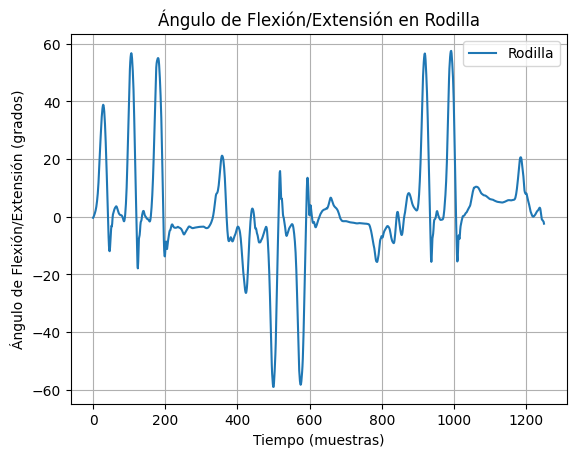

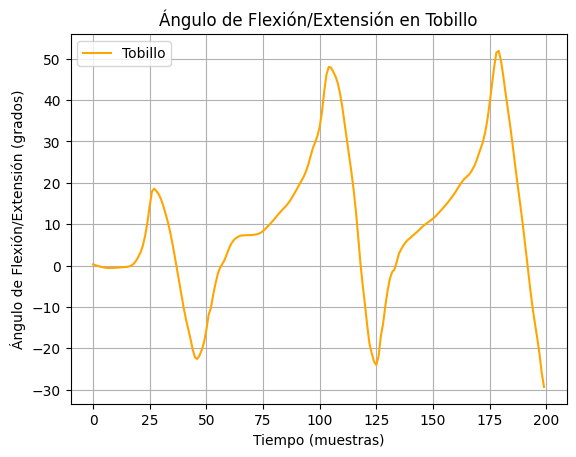

In [11]:
# Función para convertir cuaterniones a matrices de rotación
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    q = np.array([qw, qx, qy, qz])
    r = R.from_quat(q)
    return r.as_matrix()

# Función para calcular la matriz de calibración promedio
def calcular_matriz_calibracion(cuaterniones):
    """Toma un DataFrame con cuaterniones y calcula la matriz promedio de las primeras 4 filas."""
    matrices = []
    for i in range(4):  # Solo las primeras 4 filas
        qw, qx, qy, qz = cuaterniones.iloc[i]
        matriz = cuaterniones_a_rotacion(qw, qx, qy, qz)
        matrices.append(matriz)
    return np.mean(matrices, axis=0)

# Función para rotar el sistema de coordenadas del pie
def rotar_pie(rota_pie, angulo):
    """
    Rota el sensor del pie en torno al eje x (como si estuviéramos mirando al plano sagital).
    La rotación se define por el ángulo 'angulo' en grados.
    """
    # Convertir el ángulo a radianes
    angulo_rad = np.deg2rad(angulo)
    
    # Matriz de rotación alrededor del eje x
    matriz_rotacion_x = np.array([[1, 0, 0],
                                  [0, np.cos(angulo_rad), -np.sin(angulo_rad)],
                                  [0, np.sin(angulo_rad), np.cos(angulo_rad)]])
    
    # Aplicar la rotación
    return np.dot(rota_pie, matriz_rotacion_x)


#muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\muslo_der_D422CD002A96_20241123_104840.csv")
#tibia_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\tibia_der_D422CD0041E2_20241123_104840.csv")
#pie_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\datos ma vale marcha 7 sensores y ciclismo\XSENS\104840\pie_der_D422CD002A85_20241123_104840.csv")
muslo_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\muslo_der_val_D422CD002A96_20241004_110449.csv')
tibia_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\tibia_der_val_D422CD0041E2_20241004_110449.csv')
pie_data=pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\110449\pie_der_val_D422CD002A85_20241004_110449.csv')

# Asegurar que los archivos tengan la misma longitud
min_length = min(len(muslo_data), len(tibia_data), len(pie_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]
pie_data = pie_data[:min_length]

# Extraer cuaterniones
cuaterniones_muslo = muslo_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
cuaterniones_tibia = tibia_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]
cuaterniones_pie = pie_data[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']]

# Calcular matrices de calibración
matriz_calibracion_muslo = calcular_matriz_calibracion(cuaterniones_muslo)
matriz_calibracion_tibia = calcular_matriz_calibracion(cuaterniones_tibia)
matriz_calibracion_pie = calcular_matriz_calibracion(cuaterniones_pie)

# Convertir cuaterniones a matrices de rotación para todo el archivo
rotaciones_muslo = cuaterniones_muslo.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_tibia = cuaterniones_tibia.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)
rotaciones_pie = cuaterniones_pie.apply(lambda row: cuaterniones_a_rotacion(row['Quat_W'], row['Quat_X'], row['Quat_Y'], row['Quat_Z']), axis=1)

# Ajustar orientaciones al sistema anatómico usando matrices de calibración
rotaciones_anatomicas_muslo = [np.linalg.inv(matriz_calibracion_muslo) @ rot for rot in rotaciones_muslo]
rotaciones_anatomicas_tibia = [np.linalg.inv(matriz_calibracion_tibia) @ rot for rot in rotaciones_tibia]
rotaciones_anatomicas_pie = [np.linalg.inv(matriz_calibracion_pie) @ rot for rot in rotaciones_pie]

# Rotar el sensor del pie para alinear con la tibia
angulo_rotacion = 90
rotaciones_anatomicas_pie_ajustadas = [rotar_pie(rot, angulo_rotacion) for rot in rotaciones_anatomicas_pie]

# Calcular rotaciones relativas
rotaciones_relativas_rodilla = [np.linalg.inv(R_tibia) @ R_muslo for R_muslo, R_tibia in zip(rotaciones_anatomicas_muslo, rotaciones_anatomicas_tibia)]
rotaciones_relativas_tobillo = [np.linalg.inv(R_pie_ajustado) @ R_tibia for R_tibia, R_pie_ajustado in zip(rotaciones_anatomicas_tibia, rotaciones_anatomicas_pie_ajustadas)]

# Función para calcular el ángulo de flexión/extensión
def calcular_flexion_extension(rotacion_relativa):
    eje_x = np.array([1, 0, 0])  # Flexión/Extensión en el eje X
    vector_direccion = rotacion_relativa @ eje_x
    angulo_radianes = np.arctan2(vector_direccion[2], vector_direccion[0])
    return np.degrees(angulo_radianes)

# Calcular los ángulos de flexión/extensión
flexion_extension_rodilla = [calcular_flexion_extension(rot) for rot in rotaciones_relativas_rodilla]
flexion_extension_tobillo = [calcular_flexion_extension(rot) for rot in rotaciones_relativas_tobillo]

# Graficar los resultados
plt.figure()
plt.plot(flexion_extension_rodilla[0:1250], label='Rodilla')
#plt.plot(flexion_extension_tobillo[0:2000], label='Tobillo')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Ángulo de Flexión/Extensión (grados)')
plt.legend()
plt.title('Ángulo de Flexión/Extensión en Rodilla')
plt.grid()
plt.show()

# Graficar los resultados
plt.figure()
#plt.plot(flexion_extension_rodilla[0:1500], label='Rodilla')
plt.plot(flexion_extension_tobillo[0:200], label='Tobillo', color='orange')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Ángulo de Flexión/Extensión (grados)')
plt.legend()
plt.title('Ángulo de Flexión/Extensión en Tobillo')
plt.grid()
plt.show()


##### Graficando awinda de la sesión ministerio 1

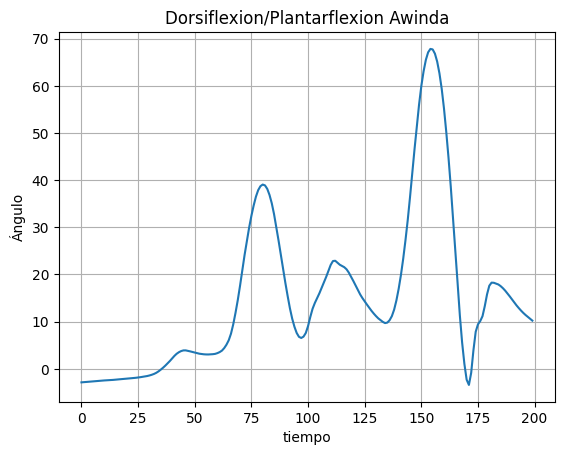

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo Excel
archivo = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\sesion 1 ministerio\Datos Awinda\Marcha-002.xlsx'

# Leer la hoja "TAL" y cargarla en un DataFrame
df = pd.read_excel(archivo, sheet_name='Joint Angles ZXY')

# Asegurarse de que la columna 'X' existe
if 'Right Knee Flexion/Extension' in df.columns:
    # Graficar los datos de la columna 'X'
    plt.plot(df['Right Knee Flexion/Extension'][0:200])
    plt.title('Dorsiflexion/Plantarflexion Awinda')
    plt.xlabel('tiempo')
    plt.ylabel('Ángulo')
    plt.grid()
    plt.show()
else:
    print("La columna 'Right Ankle Dorsiflexion/Plantarflexion' no existe en la hoja ")


#####  ESTE ES UN METODO 2 SEGMENTOS LINEALMENTE 

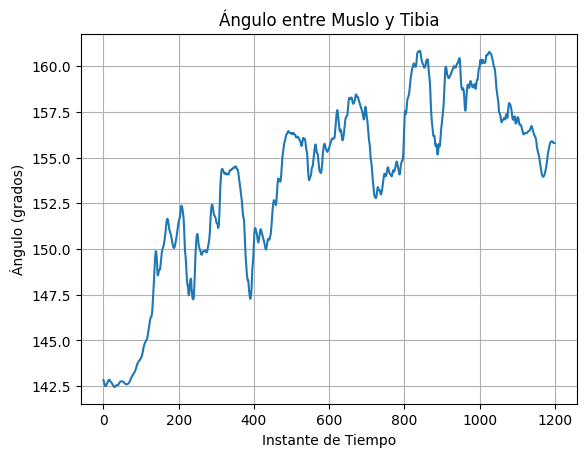

Algunos ángulos calculados: [142.830357126655, 142.76381791213427, 142.6837271135269, 142.60271788032026, 142.5369312892773, 142.49640535197983, 142.49391220902137, 142.52694629571516, 142.5694263804478, 142.61213789477674]


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

muslo_data = pd.read_csv(r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\132324\muslo_der_vale_D422CD002A84_20240827_132324.csv")
tibia_data = pd.read_csv(r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\132324\tibia_der_vale_D422CD002A8D_20240827_132324.csv')

# Asegúrate de que los archivos tengan las columnas correctas y que estén alineados
min_length = min(len(muslo_data), len(tibia_data))
muslo_data = muslo_data[:min_length]
tibia_data = tibia_data[:min_length]

# Función para calcular el ángulo entre dos cuaterniones
def calcular_angulo_q(q1, q2):
    """Calcula el ángulo entre dos cuaterniones usando la fórmula del producto punto."""
    # Producto punto entre los dos cuaterniones
    producto_punto = np.abs(np.dot(q1, q2))
    
    # Ángulo en radianes
    angulo_radianes = 2 * np.arccos(producto_punto)
    
    # Convertir el ángulo a grados
    angulo_grados = np.degrees(angulo_radianes)
    
    return angulo_grados

# Calcular los ángulos para todas las muestras
angulos = []

for i in range(min_length):
    q_muslo = muslo_data.iloc[i][['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']].values
    q_tibia = tibia_data.iloc[i][['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']].values
    angulo = calcular_angulo_q(q_muslo, q_tibia)
    angulos.append(angulo)

# Graficar los ángulos
plt.plot(angulos)
plt.title('Ángulo entre Muslo y Tibia')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Ángulo (grados)')
plt.grid(True)
plt.show()

# Mostrar algunos valores de los ángulos calculados
print("Algunos ángulos calculados:", angulos[:10])  # Mostrar los primeros 10 ángulos

#### Otras Funciones que pueden ser útiles 